<a href="https://colab.research.google.com/github/schwallergroup/ai4chem_course/blob/main/notebooks/10%20-%20Bayesian%20optimization/Buchwald-Hartwig-BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
!pip install scikit-learn-extra pytorch_lightning transformers botorch gpytorch rdkit numpy==1.26
!pip install --no-deps rxnfp
!pip install --no-deps drfp

In [3]:
!wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/10%20-%20Bayesian%20optimization/bh-reactions.csv -O bh-reactions.csv
!wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/10%20-%20Bayesian%20optimization/base_fingerprint_kernel.py -O base_fingerprint_kernel.py
!wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/10%20-%20Bayesian%20optimization/tanimoto_kernel.py -O tanimoto_kernel.py
!wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/10%20-%20Bayesian%20optimization/utils.py -O utils.py

--2025-08-05 17:38:44--  https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/10%20-%20Bayesian%20optimization/bh-reactions.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598402 (1.5M) [text/plain]
Saving to: ‘bh-reactions.csv’

bh-reactions.csv    100%[===================>]   1.52M  --.-KB/s    in 0.07s   

2025-08-05 17:38:44 (23.1 MB/s) - ‘bh-reactions.csv’ saved [1598402/1598402]

--2025-08-05 17:38:44--  https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/10%20-%20Bayesian%20optimization/base_fingerprint_kernel.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent

This tutorial is taken from [AI4Chemistry Course materials](https://github.com/schwallergroup/ai4chem_course) from EPFL.

# Introduction

In this notebook, we will be optimizing chemical reactions to maximize the yield. Our focus is on Buchwald-Hartwig cross-coupling reactions, a powerful synthetic method widely used in organic chemistry for the formation of carbon-nitrogen bonds. The yield of these reactions depends on several parameters, including the choice of ligand, base, additive, and aryl halide, making the optimization a high-dimensional complex problem.

Our dataset consists of five different reactions covering around 790 unique combinations of these parameters, providing a rich source of data for our optimization task. However, the high dimensionality of this problem makes traditional optimization methods inefficient or even infeasible (unless we have access to expensive high-throughput equipment).

To tackle this challenge, we turn to Bayesian Optimization (BO), a powerful tool for the global optimization of black-box functions. Unlike traditional optimization methods that may require exhaustive search or expensive high-throughput equipment, BO provides a principled, data-efficient approach to navigating the parameter space. This makes it particularly suitable for optimizing chemical reactions, where experimental evaluations are costly and time-consuming.

We will demonstrate the efficiency of Bayesian Optimization on the Buchwald-Hartwig dataset by comparing its performance against a baseline random search method. BO can significantly reduce the time and steps needed to reach the optimal combination of parameters, therefore maximizing yield in a data-efficient manner.


In [2]:
import pandas as pd
import torch

# Data loading

In [4]:
data = pd.read_csv('bh-reactions.csv')

In [5]:
data.head()

,reaction,ligand,additive,base,aryl halide,product,rxn,yield
0,0,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)...,C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=CC=NO1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,IC1=CC=C(CC)C=C1,CCc1ccc(Nc2ccc(C)cc2)cc1,CCc1ccc(I)cc1.Cc1ccc(N)cc1.O=S(=O)(O[Pd]1c2ccc...,21.400068
1,0,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)...,CC1=NOC=C1,CN1CCCN2C1=NCCC2,ClC1=CC=C(CC)C=C1,CCc1ccc(Nc2ccc(C)cc2)cc1,CCc1ccc(Cl)cc1.Cc1ccc(N)cc1.O=S(=O)(O[Pd]1c2cc...,1.922792
2,0,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)...,O=C(OC)C1=CC=NO1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,BrC1=CC=C(CC)C=C1,CCc1ccc(Nc2ccc(C)cc2)cc1,CCc1ccc(Br)cc1.Cc1ccc(N)cc1.O=S(=O)(O[Pd]1c2cc...,15.673040
3,0,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[...,CC1=CC=NO1,CN1CCCN2C1=NCCC2,IC1=CC=C(CC)C=C1,CCc1ccc(Nc2ccc(C)cc2)cc1,CCc1ccc(I)cc1.Cc1ccc(N)cc1.O=S(=O)(O[Pd]1c2ccc...,76.225051
4,0,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)...,C1(C2=CC=CC=C2)=CON=C1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,IC1=CC=C(CC)C=C1,CCc1ccc(Nc2ccc(C)cc2)cc1,CCc1ccc(I)cc1.Cc1ccc(N)cc1.O=S(=O)(O[Pd]1c2ccc...,15.011788


In [6]:
len(data['reaction'].unique())


5

Can you check the size of the search space for each of the reactions? The design space is built as a product of the number of different parameters. So if we have to test 3 ligands and 5 bases, the search space would be 15 combinations of ligands and bases.

*Hint*: we already mention the size of the search space for each reaction in the introduction part. Try to uncover that number directly from the data.

In [ ]:
# TODO:
total_combinations =

# Data featurization

To use Bayesian Optimization, we need to transform our raw data into a form that can be processed by our machine learning models through the process of data featurization. We can choose from several methods of featurization for chemical reactions, each with its own trade-offs in terms of computational cost and predictive accuracy.

Density Functional Theory (DFT) is a popular method to represent chemical reactions. It is a computational technique used in physics and chemistry to investigate the electronic structure (principally the ground state) of many-body systems, in particular atoms, molecules, and the condensed phases. DFT calculations are highly accurate and can provide a wealth of information about the system, but they are also computationally expensive.

For faster and more efficient featurization, we can use fingerprinting methods. These methods transform the chemical structure into a fixed-length numerical vector (or "fingerprint") that captures the key features of the structure. There are different types of fingerprints, each capturing different aspects of the chemical structure.

One-Hot Encoding (OHE): OHE is a simple and fast method of featurization that can be used when the data consists of a finite set of discrete values (like categories). Each category is mapped to a vector that contains 1 in the position corresponding to the category and 0 in all other positions. OHE is computationally efficient and easy to use, but it doesn't capture any relationships between the categories.

DRFP (Differential Reaction Fingerprint): The DRFP algorithm takes a reaction represented in the SMILES format as input and generates a binary fingerprint. The fingerprint is based on the symmetric difference of two sets, each containing the circular molecular n-grams generated from the molecules listed on the left and right of the reaction arrow, respectively. Importantly, DRFP does not need to distinguish between reactants and reagents.

RXNFP (Reaction Fingerprint): RXNFP is a continuous, data-driven representation of chemical reactions derived from deep neural networks, specifically transformer models, trained for the task of reaction classification. As a fully data-driven method, RXNFP is adaptable and can provide a robust representation of different reactions. This adaptability, combined with the high performance of deep neural networks, enables RXNFP to efficiently represent the complex relationships between molecular structures and their reactivity, making it a strong candidate for use in Bayesian Optimization.

We will compare the performance of these different featurization methods in the context of Bayesian Optimization.

## OHE


In [7]:
from utils import one_hot

ohe_features = one_hot(data[data['reaction']==0][['ligand','additive', 'base', 'aryl halide']])
ohe_features.shape

(790, 32)

## DRFP

In [8]:
from utils import drfp

drfp_features = drfp(data[data['reaction']==0]['rxn'])
drfp_features.shape

(790, 2048)

## RXNFP

In [9]:
from utils import rxnfp

rxnfp_features = rxnfp(data[data['reaction']==0]['rxn'])
rxnfp_features.shape

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


(790, 256)

# Data selection

Because we have to start from somewhere. 🤷

While the full search space size can be overwhelming, we need to start from a small subset of all the possible combinations and start our BO search using some initial data. The way we select the initial data can also contribute highly to the overall success of the search campaign. So it's better not to select the data randomly. There are techniques, like clustering and maximin strategy (starting from one random point in the space and selecting the rest of the set so that it maximizes the minimum distance between all the points in the selected set) that can help us select diverse initial sample set.

In [10]:
import torch
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

class BOInitData:
    def __init__(self,
                 n: int = 10,
                 method: str = 'random',
                 metric: str = 'jaccard',
                 cluster_init: str = 'random',
                 seed: int = 42):
        self.n = n
        self.method = method
        self.seed = seed
        self.metric = metric
        self.cluster_init = cluster_init

        self.method_map = {
            'kmedoids': self.kmedoids,
            'kmeans': self.kmeans,
            'max_min_dist': self.max_min_dist,
            'random': self.random,
        }

    def fit(self, x):
        init_method = self.method_map.get(self.method)
        if init_method is None:
            raise ValueError(f"Unrecognized initialization method '{self.method}'")
        return init_method(x)

    def kmedoids(self, x):
        kmedoids = KMedoids(
            n_clusters=self.n,
            init=self.cluster_init,
            random_state=self.seed,
            metric=self.metric,
            max_iter=5000,
        ).fit(x)
        selected = torch.tensor(kmedoids.medoid_indices_.tolist())
        return selected

    def kmeans(self, x):
        scaler = StandardScaler()
        x_init_normalized = scaler.fit_transform(x)
        kmeans = KMeans(
            n_clusters=self.n,
            init=self.cluster_init,
            random_state=self.seed,
            max_iter=5000,
        ).fit(x_init_normalized)
        centroids = torch.tensor(kmeans.cluster_centers_)
        selected = torch.argmin(torch.norm(torch.from_numpy(x).unsqueeze(1) - centroids, dim=2), dim=0)
        return selected

    def max_min_dist(self, x):
        distances = cdist(x, x, metric=self.metric)
        selected = torch.tensor([torch.randint(0, distances.shape[0], (1,))])
        for i in range(self.n - 1):
            coverage = torch.min(torch.tensor(distances)[:, selected], axis=1)
            selected = torch.cat([selected, coverage.argmax().unsqueeze(0)])
        return selected

    def random(self, x):
        selected = torch.randperm(len(x))[: self.n]
        return selected


In [11]:
bo_init_data = BOInitData(method='max_min_dist', metric='jaccard')


## DataModule

Now let's put all these things together in a DataModule.

In [12]:
import pytorch_lightning as pl
import torch
from typing import Optional
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

class BODataModule(pl.LightningDataModule):
    def __init__(self, dataset: str = "buchwald-hartwig",
        data_path: str = "bh-reactions.csv",
        reaction: int = 0,
        representation: str = "drfp",
        feature_dimension: int = 2048,
        bond_radius: int = 3,
        init_data: BOInitData = BOInitData(),
    ):
        super().__init__()
        self.dataset = dataset
        self.data_path = data_path
        self.reaction = reaction
        self.representation = representation
        self.feature_dimension = feature_dimension
        self.bond_radius = bond_radius
        self.init_data = init_data
        self.setup()

    def featurize(self):
        if self.representation == "ohe":
            self.x = one_hot(self.data[['ligand','additive',	'base',	'aryl halide']])
        elif self.representation == "drfp":
            self.x = drfp(self.data['rxn'])
        elif self.representation == "rxnfp":
            self.x = rxnfp(self.data['rxn'])

        self.y = self.data['yield'].values.reshape(-1, 1)

    def setup(self, stage: Optional[str] = None) -> None:
        self.data = pd.read_csv(self.data_path)
        self.data = data[self.data['reaction'] == self.reaction]
        self.featurize()

        init_indices = self.init_data.fit(self.x)
        self.train_test_split(init_indices)

    def train_test_split(self, init_indices):
        self.train_x = torch.from_numpy(self.x[init_indices]).to(torch.float64)
        self.train_y = torch.from_numpy(self.y[init_indices]).to(torch.float64)

        # Create a boolean mask to select the remaining indices
        heldout_mask = torch.ones(len(self.x), dtype=torch.bool)
        heldout_mask[init_indices] = False

        self.heldout_x = torch.from_numpy(self.x[heldout_mask]).to(torch.float64)
        self.heldout_y = torch.from_numpy(self.y[heldout_mask]).to(torch.float64)

    def train_dataloader(self):
        train_dataset = TensorDataset(self.features[self.train_data.index], self.train_data['yield'])
        return DataLoader(train_dataset, batch_size=len(self.train_data))

    def heldout_dataloader(self):
        heldout_dataset = TensorDataset(self.features[self.heldout_data.index], self.heldout_data['yield'])
        return DataLoader(heldout_dataset, batch_size=len(self.heldout_data))



In [13]:
dm = BODataModule(representation='ohe')

In [14]:
dm.train_x.shape

torch.Size([10, 32])

## Surrogate Model

Next we need a strong surrogate model to help us find patterns and provide an informative overview of the underlying function that describes our data. We use Botorch library and build a Gaussian Process surrogate model. It requires training data and the kernel which we can use from gpytorch or gauche libraries.

In [15]:
from botorch.models.gp_regression import SingleTaskGP
from gpytorch.kernels import Kernel, ScaleKernel
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from tanimoto_kernel import TanimotoKernel

class GP(SingleTaskGP):
    def __init__(
        self,
        train_x: torch.Tensor,
        train_y: torch.Tensor,
        kernel: Kernel = None,
        standardize: bool = True,
        normalize: bool = False,
    ):
        self._set_dimensions(train_X=train_x, train_Y=train_y)

        super().__init__(
            train_x,
            train_y,
            covar_module=ScaleKernel(base_kernel=kernel),
            outcome_transform=Standardize(train_y.shape[-1]) if standardize else None,
            input_transform=Normalize(train_x.shape[-1]) if normalize else None,
        )

        self.kernel = kernel
        self.standardize = standardize
        self.normalize = normalize

    def reinit(self, train_x, train_y):
        return GP(
            train_x,
            train_y,
            self.kernel,
            self.standardize,
            self.normalize,
        )


# BO

Finally we'll optimize our reactions using Bayesian optimization and compare it to random search. The procedure includes:
1. selecting some initial data points to train the surrogate model (in code: ```init_data=BOInitData(method='random', metric='jaccard', cluster_init='k-means++', seed=seed)```)
2. generating some suggestions from the trained surrogate model and acquisition function (in code: ```best_candidate = heldout_x[best_candidate_idx]```)
3. evaluating these suggestions (in real-life scenario this means running the proposed experiment in the lab; in our case it means reading the *yield* value from our dataset)
4. adding a new training point to the training dataset (removing the same point from the heldout set) (
        
        train_x = torch.vstack([train_x, heldout_x[idx]])
        train_y = torch.vstack([train_y, heldout_y[idx]])
        heldout_x = torch.cat([heldout_x[:best_candidate_idx], heldout_x[best_candidate_idx+1:]])
        heldout_y = torch.cat([heldout_y[:best_candidate_idx], heldout_y[best_candidate_idx+1:]]))
5. retraining the model and repeating actions from 2. on.


In [16]:
import gpytorch
from gpytorch import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll
from pytorch_lightning import seed_everything
from botorch.acquisition import UpperConfidenceBound

def run_bo(dm):
    train_x, train_y = dm.train_x, dm.train_y
    heldout_x, heldout_y = dm.heldout_x, dm.heldout_y
    num_iterations = 30
    gp = GP(train_x, train_y, kernel=TanimotoKernel())
    gp.double()
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

    best_value = train_y.max().item()
    best_values = [best_value]
    for i in range(num_iterations):
        with gpytorch.settings.fast_computations(covar_root_decomposition=False):
            fit_gpytorch_mll(mll, max_retries=50)

        acq_func = UpperConfidenceBound(gp, beta=0.25)
        acq_values = acq_func(heldout_x.unsqueeze(-2))
        best_candidate_idx = acq_values.view(-1).argmax()
        best_candidate = heldout_x[best_candidate_idx]
        train_x = torch.vstack([train_x, best_candidate])
        train_y = torch.vstack([train_y, heldout_y[best_candidate_idx]])
        heldout_x = torch.cat([heldout_x[:best_candidate_idx], heldout_x[best_candidate_idx+1:]])
        heldout_y = torch.cat([heldout_y[:best_candidate_idx], heldout_y[best_candidate_idx+1:]])

        gp = gp.reinit(train_x, train_y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

        new_best_value = train_y.max().item()
        if new_best_value > best_value:
            best_value = new_best_value
        best_values.append(best_value)
    return np.array(best_values)

def run_random_search(dm):
    train_x, train_y = dm.train_x, dm.train_y
    heldout_x, heldout_y = dm.heldout_x, dm.heldout_y
    num_iterations = 30
    best_value = train_y.max().item()
    best_values = [best_value]
    for _ in range(num_iterations):
        idx = torch.randint(heldout_x.size(0), (1,))
        train_x = torch.vstack([train_x, heldout_x[idx]])
        train_y = torch.vstack([train_y, heldout_y[idx]])
        heldout_x = torch.cat([heldout_x[:idx], heldout_x[idx+1:]])
        heldout_y = torch.cat([heldout_y[:idx], heldout_y[idx+1:]])
        new_best_value = train_y.max().item()
        if new_best_value > best_value:
            best_value = new_best_value
        best_values.append(best_value)
    return np.array(best_values)

import numpy as np
from tqdm import tqdm
progress_bar = tqdm(total=30)

representations = ['ohe', 'rxnfp', 'drfp']
reactions = [0] # 1, 2, 3, 4]  # replace when working with other reactions
seeds = range(2) # increase number of seeds for a better estimate of the variation of yield prediction, 2 is chosen for faster computation

results = {}

for representation in representations:
    results[representation] = {}
    for reaction in reactions:
        results[representation][reaction] = {'bo': [], 'random': []}
        for seed in seeds:
            seed_everything(seed)
            # Run BO
            dm = BODataModule(reaction=reaction, representation=representation, init_data=BOInitData(method='random', metric='jaccard', cluster_init='k-means++', seed=seed))
            best_values_bo = run_bo(dm)
            # Run random search
            dm = BODataModule(reaction=reaction, representation=representation)
            best_values_random = run_random_search(dm)
            # Store results
            results[representation][reaction]['bo'].append(best_values_bo)
            results[representation][reaction]['random'].append(best_values_random)
            progress_bar.update(1)



 33%|███▎      | 10/30 [00:32<01:03,  3.19s/it]INFO:lightning_fabric.utilities.seed:Seed set to 0
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
 37%|███▋      | 11/30 [02:44<13:29, 42.62s/it]INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWa

## Visualization
Now let's plot our results.
Are we better than the random search?

Can you show these results for some of the other reactions?

What do you observe? What representation works the best?

Can you change the way we select the initial data points (*hint* change the parameters of the init_data argument of the BODataModule)?

Which initialization strategy is the best?

Can you update the plot with the max yield value for the specific reaction?

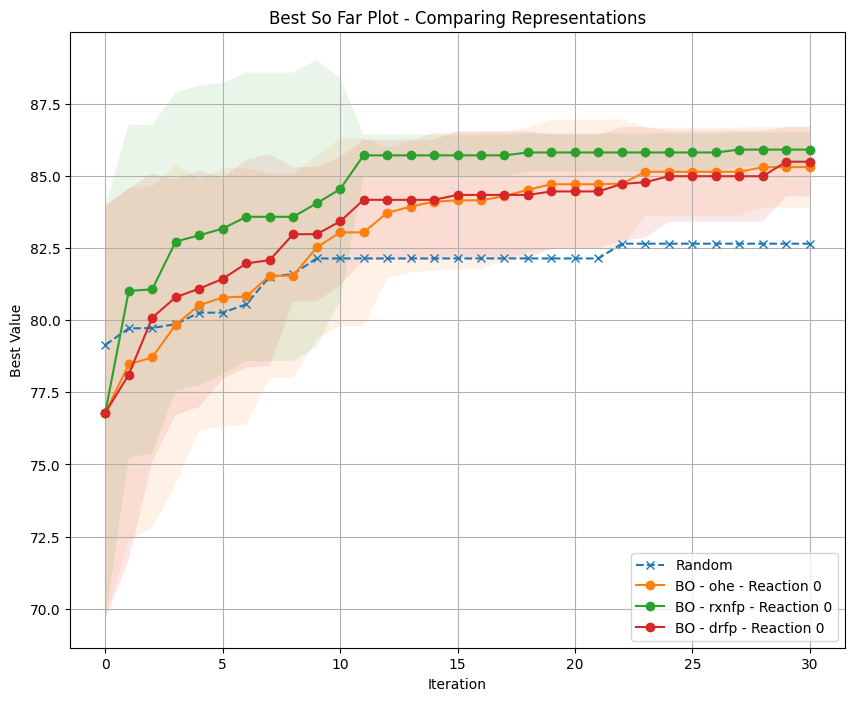

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
reaction = 0

mean_random = np.mean([np.mean(results[rep][reaction]['random'], axis=0) for rep in representations], axis=0)
std_random = np.std([np.std(results[rep][reaction]['random'], axis=0) for rep in representations], axis=0)

plt.plot(mean_random, label='Random', marker='x', linestyle='--')
plt.fill_between(range(len(mean_random)), mean_random-std_random, mean_random+std_random, alpha=0.1)

for representation in representations:
    for reaction in reactions:
        mean_bo = np.mean(results[representation][reaction]['bo'], axis=0)
        std_bo = np.std(results[representation][reaction]['bo'], axis=0)

        plt.plot(mean_bo, label=f'BO - {representation} - Reaction {reaction}', marker='o')
        plt.fill_between(range(len(mean_bo)), mean_bo-std_bo, mean_bo+std_bo, alpha=0.1)

plt.title("Best So Far Plot - Comparing Representations")
plt.xlabel('Iteration')
plt.ylabel('Best Value')
plt.legend()
plt.grid(True)
plt.show()


### Additional material on BO for chemistry

If you would like to see how to run a BO campaign incorporating other parameters like temperature or concentration, we recommend you to see [this tutorial](https://github.com/PatWalters/practical_cheminformatics_tutorials/blob/main/reaction/bayesian_reaction_optimization.ipynb) by Pat Walters using [BayBE](https://emdgroup.github.io/baybe/stable/index.html).